## Статистический анализ данных

Исследование данных популярного сервиса аренды самокатов GoFast. В датасетах содержатся данные о некоторых пользователях из нескольких городов, а также об их поездках. Требуется выполнить анализ и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from math import factorial, exp, sqrt
from scipy import stats as st
from scipy.stats import binom, norm
from scipy.stats import levene

#### Шаг 1. Загрузка данных

In [2]:
data_users = pd.read_csv('D:\\ds\\users_go.csv')
data_rides = pd.read_csv('D:\\ds\\rides_go.csv')
data_subs = pd.read_csv('D:\\ds\\subscriptions_go.csv')
pd.set_option('display.max_columns', None)

In [3]:
data_users.head(5)

user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra

In [4]:
data_rides.head(5)

user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28

In [5]:
data_subs

subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199

In [6]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


#### Шаг 2. Предобработка данных

Начинаю предобработку: отформатирую дату, добавлю колонку с номером месяца, поищу явные дубликаты.

In [9]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')
data_rides['month'] = data_rides['date'].dt.month
print(data_users.duplicated().sum())
print(data_rides.duplicated().sum())

31
0


In [10]:
data_users = data_users.drop_duplicates()

На этом всё. Тип данных везде выглядит корректно, пропуски отсутствуют.

#### Шаг 3. Исследовательский анализ данных

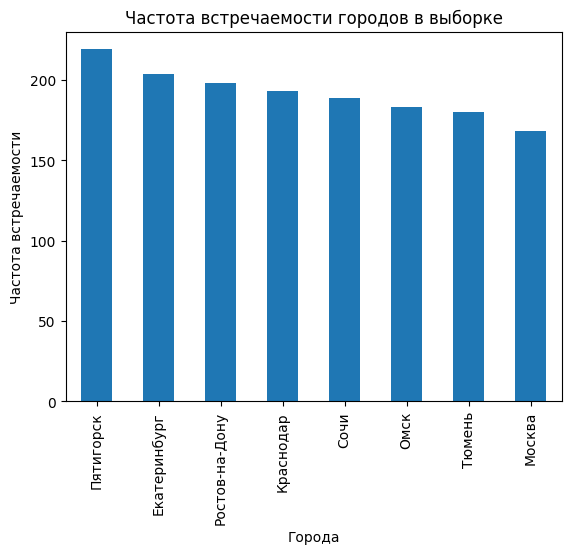

In [11]:
data_users['city'].value_counts().plot(kind='bar')
plt.xlabel('Города')
plt.ylabel('Частота встречаемости')
plt.title('Частота встречаемости городов в выборке')
plt.show()

In [12]:
data_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

В выборке присутствуют 4 южных города, 3 сибирских и столица. Причём, Москва в выборке встречается реже всего. Видимо, это обусловлено высокой конкурентностью рынка проката в городе. Чаще всего встречается Пятигорск. Небольшой курортный город, являющийся транспортным хабом региона КМВ. Похоже, прокатные самокаты там востребованы.

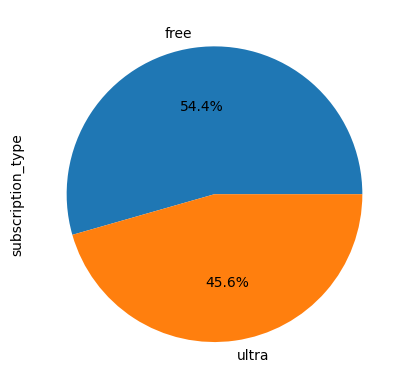

In [13]:
data_users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.1f%%');

Чуть больше половины наблюдаемых пользователей не имеют абонентской подписки.

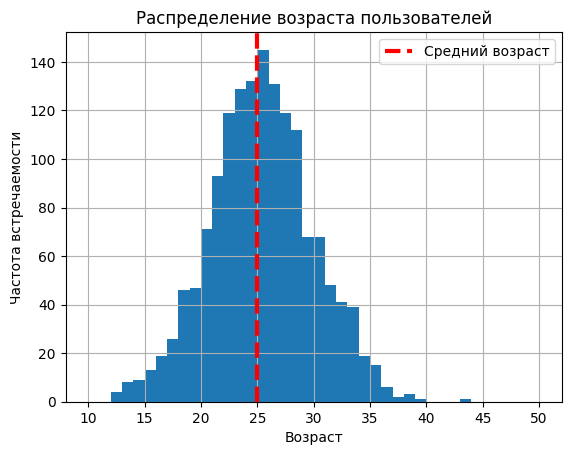

In [14]:
data_users['age'].hist(bins=40, range=(10, 50));
plt.xlabel('Возраст')
plt.ylabel('Частота встречаемости')
plt.title('Распределение возраста пользователей')
plt.axvline(x=25, color='r', linestyle='--', linewidth=3, label='Средний возраст')
plt.legend()
plt.show()

In [15]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Распределение возраста похоже на нормальное. Мода, среднее и медиана - 25 лет.

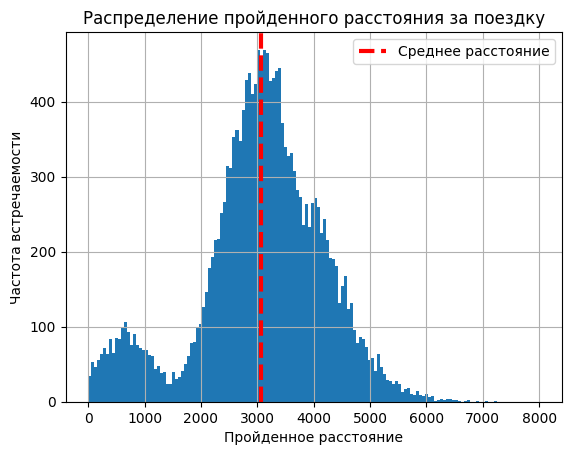

In [16]:
data_rides['distance'].hist(bins=150, range=(0, 8000));
plt.xlabel('Пройденное расстояние')
plt.ylabel('Частота встречаемости')
plt.title('Распределение пройденного расстояния за поездку')
plt.axvline(x=3070, color='r', linestyle='--', linewidth=3, label='Среднее расстояние')
plt.legend()
plt.show()

In [17]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Расстояние за поездку имеет смешанное распределение, состоящее из двух, близких к нормальным. На графике видно распределение коротких поездок со средним около 650м и дальних со средним примерно 3км. Медианное среднее по всей выборке составляет 3,1км. Длительных поездок существенно больше, чем коротких. Справа виден хвост из редких поездок на расстояние более 5км. Наличие пары пиков дистанций наталкивает на мысль, что может быть несколько сценариев пользования приложением и с этими категориями стоит отдельно работать.

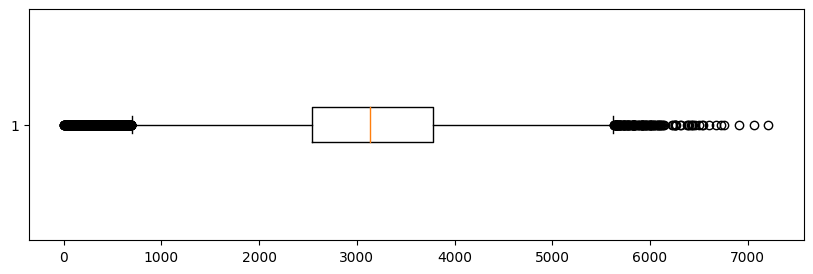

In [18]:
plt.figure(figsize=(10, 3)) 
plt.boxplot(data_rides['distance'], vert=False);

Боксплот определяет выбросами значения менее 650м и более 5,7км. Но сильно выдающихся точек не видно, всё похоже на правду, поэтому оставляю выбросы как есть.

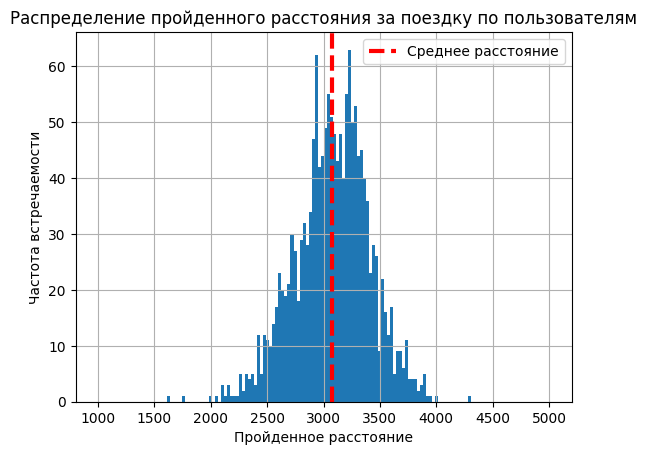

In [19]:
rides_table = data_rides.pivot_table(index='user_id', values='distance', aggfunc='mean')
rides_table.hist(bins=150, range=(1000, 5000));
plt.xlabel('Пройденное расстояние')
plt.ylabel('Частота встречаемости')
plt.title('Распределение пройденного расстояния за поездку по пользователям')
plt.axvline(x=3077, color='r', linestyle='--', linewidth=3, label='Среднее расстояние')
plt.legend()
plt.show()

Распределение среднего пройденного расстояния по пользователям близко к нормальному.

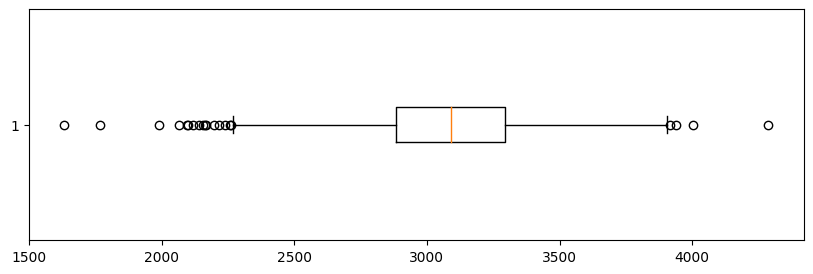

In [20]:
plt.figure(figsize=(10, 3)) 
plt.boxplot(rides_table, vert=False);

Видно, что есть некоторые пользователи, которые выбиваются из общей массы в пройденном расстоянии, но есть и такие, чьи поездки короче обычных.  

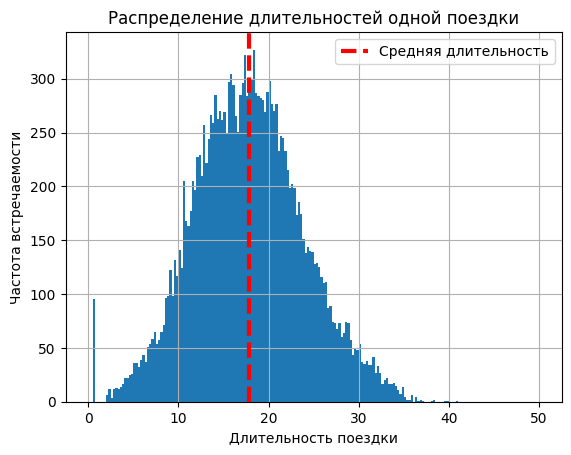

In [21]:
data_rides['duration'].hist(bins=200, range=(0, 50));
plt.xlabel('Длительность поездки')
plt.ylabel('Частота встречаемости')
plt.title('Распределение длительностей одной поездки')
plt.axvline(x=17.8, color='r', linestyle='--', linewidth=3, label='Средняя длительность')
plt.legend()
plt.show()

In [22]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

На графике видно необычно короткие сессии, длительностью менее минуты. Сделаю срез и посмотрю их характеристики.

In [23]:
data_rides.query('duration < 1')

user_id     distance  duration       date  month
6531       701  4196.445201       0.5 2021-08-31      8
6570       704  4830.824371       0.5 2021-10-14     10
6680       712  4684.004397       0.5 2021-03-04      3
6695       713  5215.642710       0.5 2021-02-25      2
6768       718  5197.436649       0.5 2021-02-11      2
...        ...          ...       ...        ...    ...
17004     1460  5531.335845       0.5 2021-01-19      1
17242     1477  6724.932981       0.5 2021-01-12      1
17314     1483  4445.481070       0.5 2021-03-06      3
17505     1496  5722.551787       0.5 2021-02-14      2
17909     1524  4103.998874       0.5 2021-06-18      6

[95 rows x 5 columns]

Все сессии подозрительно имеют длительность в полминуты, при этом дистанция, пройденная за такую сессию, значительна. Видимо, это ошибка логгирования. Нужно очистить датасет от таких записей.

In [24]:
data_rides = data_rides[data_rides['duration'] != 0.5]

#### Шаг 4. Объединение данных

Объединю данные о пользователях, поездках и подписках в один датафрейм.

In [25]:
merged_data = pd.merge(data_users, data_rides, on='user_id', how='inner')
data_merged = pd.merge(merged_data, data_subs, on='subscription_type', how='left')
data_merged.head(5)

user_id  name  age    city subscription_type     distance   duration  \
0        1  Кира   22  Тюмень             ultra  4409.919140  25.599769   
1        1  Кира   22  Тюмень             ultra  2617.592153  15.816871   
2        1  Кира   22  Тюмень             ultra   754.159807   6.232113   
3        1  Кира   22  Тюмень             ultra  2694.783254  18.511000   
4        1  Кира   22  Тюмень             ultra  4028.687306  26.265803   

        date  month  minute_price  start_ride_price  subscription_fee  
0 2021-01-01      1             6                 0               199  
1 2021-01-18      1             6                 0               199  
2 2021-04-20      4             6                 0               199  
3 2021-08-11      8             6                 0               199  
4 2021-08-28      8             6                 0               199

Теперь разделю его на пользователей с подпиской и без и сравню визуализации данных.

In [26]:
sub_free = data_merged[data_merged['subscription_type'] == 'free']
sub_ultra = data_merged[data_merged['subscription_type'] == 'ultra']

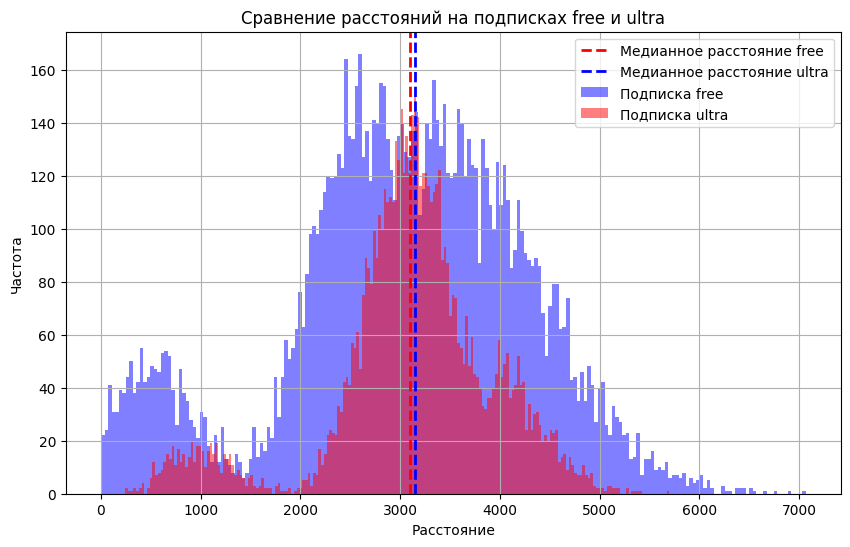

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(sub_free['distance'], bins=200, alpha=0.5, label='Подписка free', color='blue')  
plt.hist(sub_ultra['distance'], bins=200, alpha=0.5, label='Подписка ultra', color='red')  
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.title('Сравнение расстояний на подписках free и ultra') 
plt.grid(True)
plt.axvline(x=3102, color='r', linestyle='--', linewidth=2, label='Медианное расстояние free')
plt.axvline(x=3149, color='b', linestyle='--', linewidth=2, label='Медианное расстояние ultra')
plt.legend()
plt.show()

In [28]:
sub_free['distance'].describe()

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

In [29]:
sub_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

В целом распределения схожи по форме. Пользователи без подписки чаще ездят на короткие дистанции и разброс значений вокруг среднего  на длинных дистанциях у них существенно больше. Пользователи с подпиской предпочитают средние дистанции с меньшим разбросом вокруг среднего 3,1км.

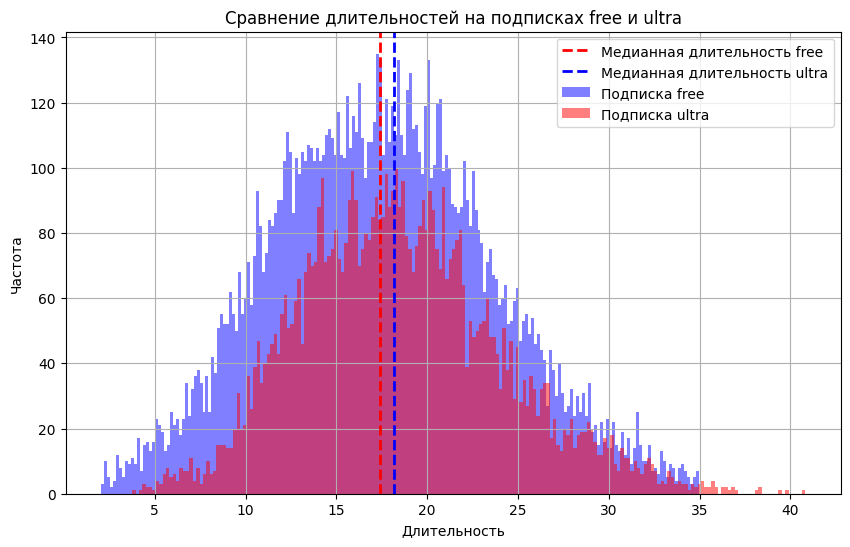

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(sub_free['duration'], bins=200, alpha=0.5, label='Подписка free', color='blue')  
plt.hist(sub_ultra['duration'], bins=200, alpha=0.5, label='Подписка ultra', color='red')  
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.title('Сравнение длительностей на подписках free и ultra') 
plt.axvline(x=17.38, color='r', linestyle='--', linewidth=2, label='Медианная длительность free')
plt.axvline(x=18.18, color='b', linestyle='--', linewidth=2, label='Медианная длительность ultra')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
sub_free['duration'].describe()

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

In [32]:
sub_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Распределение длительностей поездок у пользователей обеих категорий ещё более схоже. Разница в разбросе вокруг среднего менее выражена. Пользователи с подпиской реже ездят менее 5 минут, но медианная длительность у пользователей без подписки чуть больше.

#### Шаг 5. Подсчёт выручки

Создам датафрейм с агрегированными данными о поездках, найду суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Туда же добавлю распределение помесячной выручки, которую принёс каждый пользователь. Рассчитаю её по формуле: (стоимость старта поездки × количество поездок) + (стоимость одной минуты поездки × общая продолжительность всех поездок в минутах) + стоимость подписки.

In [33]:
data_merged['duration'] = np.ceil(data_merged['duration'])
data_merged['distance'] = np.ceil(data_merged['distance']) #округлю продолжительность и расстояние поездки

In [34]:
sum_table = (
    data_merged.pivot_table(
        index='user_id', 
        columns='month', 
        values=['distance', 'duration'], 
        aggfunc={
            'distance': ['sum', 'count'], 
            'duration': 'sum'
        }
    )
    .fillna(0)
    .astype('int64')
)
sum_table.head(5)

distance                                                            \
           count                                    sum                      
month         1  2  3  4  5  6  7  8  9  10 11 12    1     2      3     4    
user_id                                                                      
1              2  0  0  1  0  0  0  2  0  2  3  2  7028     0      0   755   
2              0  0  3  2  0  1  2  1  0  1  0  1     0     0  10190  6165   
3              1  2  0  1  3  0  3  0  1  0  0  1  3062  5422      0  2957   
4              0  2  0  0  0  2  3  1  0  4  2  0     0  6341      0     0   
5              1  1  3  1  2  0  1  1  0  1  0  0  3915  2562  10635  3374   

                                                          duration          \
                                                               sum           
month      5     6      7     8     9      10    11    12       1   2   3    
user_id                                                                      
1           0     0      0  6724     0   5811  7005  6753       42   0   0   
2           0  3256   6781   924     0   2825     0  3829        0   0  63   
3        9065     0  10921     0  2892      0     0  2594       13  39   0   
4           0  6754  10492  4650     0  13263  3344     0        0  49   0   
5        5825     0   3312  2721     0   3219     0     0       13  12  57   

                                             
                                             
month    4   5   6   7   8   9   10  11  12  
user_id                                      
1         7   0   0   0  46   0  32  56  28  
2        40   0  14  48   7   0  19   0  12  
3        21  63   0  67   0  23   0   0  13  
4         0   0  45  56  36   0  79  28   0  
5        15  33   0  12  18   0  20   0   0

sum_table сгруппирована по уникальным user_id, а количество поездок, пройденное расстояние и длительность поездок распределены по колонкам месяцев. Избавлюсь от мультииндексов.

In [35]:
sum_table.columns = ['_'.join(map(str, col)) for col in sum_table.columns]
sum_table = sum_table.reset_index()

Теперь для расчетов нужно добавить строки с информацией о тарифах.

In [36]:
data_filtered = ((data_merged[['user_id', 'subscription_type','minute_price', 'start_ride_price', 'subscription_fee']])
                 .drop_duplicates())
final_table = pd.merge(sum_table, data_filtered, on='user_id', how='inner')

Осталось только посчитать выручку. Заверну формулу в цикл и переберу значения во всех столбцах, после чего сформирую новые со значениями выручки.

In [42]:
for i in range(1, 13):
    final_table[f'revenue_{i}'] = (final_table['start_ride_price'] * final_table[f'distance_count_{i}']) + \
                                    (final_table['minute_price'] * final_table[f'duration_sum_{i}']) + \
                                    final_table['subscription_fee']
final_table.head(5)

user_id  distance_count_1  distance_count_2  distance_count_3  \
0        1                 2                 0                 0   
1        2                 0                 0                 3   
2        3                 1                 2                 0   
3        4                 0                 2                 0   
4        5                 1                 1                 3   

   distance_count_4  distance_count_5  distance_count_6  distance_count_7  \
0                 1                 0                 0                 0   
1                 2                 0                 1                 2   
2                 1                 3                 0                 3   
3                 0                 0                 2                 3   
4                 1                 2                 0                 1   

   distance_count_8  distance_count_9  distance_count_10  distance_count_11  \
0                 2                 0                  2                  3   
1                 1                 0                  1                  0   
2                 0                 1                  0                  0   
3                 1                 0                  4                  2   
4                 1                 0                  1                  0   

   distance_count_12  distance_sum_1  distance_sum_2  distance_sum_3  \
0                  2            7028               0               0   
1                  1               0               0           10190   
2                  1            3062            5422               0   
3                  0               0            6341               0   
4                  0            3915            2562           10635   

   distance_sum_4  distance_sum_5  distance_sum_6  distance_sum_7  \
0             755               0               0               0   
1            6165               0            3256            6781   
2            2957            9065               0           10921   
3               0               0            6754           10492   
4            3374            5825               0            3312   

   distance_sum_8  distance_sum_9  distance_sum_10  distance_sum_11  \
0            6724               0             5811             7005   
1             924               0             2825                0   
2               0            2892                0                0   
3            4650               0            13263             3344   
4            2721               0             3219                0   

   distance_sum_12  duration_sum_1  duration_sum_2  duration_sum_3  \
0             6753              42               0               0   
1             3829               0               0              63   
2             2594              13              39               0   
3                0               0              49               0   
4                0              13              12              57   

   duration_sum_4  duration_sum_5  duration_sum_6  duration_sum_7  \
0               7               0               0               0   
1              40               0              14              48   
2              21              63               0              67   
3               0               0              45              56   
4              15              33               0              12   

   duration_sum_8  duration_sum_9  duration_sum_10  duration_sum_11  \
0              46               0               32               56   
1               7               0               19                0   
2               0              23                0                0   
3              36               0               79               28   
4              18               0               20                0   

   duration_sum_12 subscription_type  minute_price  start_ride_price  \
0               28             ultra          

#### Шаг 6. Проверка гипотез

Нужно понять, тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки? Формулирую гипотезы:<br>
**Н0: средние длительности поездок пользователей из двух групп равны.<br>
H1: среднее значение длительности поездки пользователей с подпиской больше, чем среднее значение длительности поездки пользователей без подписки.**

In [43]:
free_series = data_merged.loc[data_merged['subscription_type'] == 'free', 'duration']
ultra_series = data_merged.loc[data_merged['subscription_type'] == 'ultra', 'duration'] #формирую две совокупности

Для того, чтоб проверить их дисперсии, проведу тест Левене.

In [45]:
statistic, p_value = levene(free_series, ultra_series)
print("Statistic:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу: дисперсии равны.")
else:
    print("Отвергаем нулевую гипотезу: дисперсии различаются.")

Statistic: 101.3208376241293
p-value: 9.044209262913687e-24
Отвергаем нулевую гипотезу: дисперсии различаются.


Разность дисперсий нужно учесть при проверке гипотез.

In [47]:
alpha = 0.005
results = st.ttest_ind(ultra_series, free_series, equal_var=False, alternative='greater')
print(f'p-value: {results.pvalue:.38f}')
if results.pvalue < alpha:
    
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.00000000000000000000000000003086332093
Отвергаем нулевую гипотезу


Столь малое p-value говорит о том, что вероятность получить равные средние длительности (получить их разность равную нулю) крайне мала, а вероятность получить такой результат случайно крайне низка. На этом основании нулевая гипотеза отвергается в пользу альтернативной, из чего можно сделать вывод, что среднее значение длительности поездки у пользователей с подпиской будет выше.

Второй вопрос звучит так: Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Формулирую гипотезы:<br>
**H0: среднее расстояние, которое проезжают пользователи с подпиской, равно 3130 метров.<br>
H1: среднее расстояние, которое проезжают пользователи с подпиской, меньше 3130 метров.**

In [48]:
distance_series = data_merged.loc[data_merged['subscription_type'] == 'ultra', 'distance'] #формирую выборку

In [51]:
optimal_distance = 3130
alpha = 0.05
results = st.ttest_1samp(distance_series, optimal_distance, alternative='less')
print(f'p-value: {results.pvalue:.3f}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.088
Нет оснований отвергнуть нулевую гипотезу


Значение p-value говорит о том, что вероятность получить наблюдаемое значение 3130 или ещё более далёкое от наблюдаемого в меньшую сторону при условии, что нулевая гипотеза верна, составляет 8.8%. Учитывая выбранный уровень статистической значимости 5%, нет достаточных оснований отвергнуть нулевую гипотезу. Таким образом, нельзя сделать вывод о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров.

Далее нужно проверить гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.<br>
**H0: средняя помесячная выручка от пользователей с подпиской и от пользователей без подписки равны.<br>
H1: средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.**

In [52]:
revenue_columns = [f'revenue_{i}' for i in range(1, 13)] + ['subscription_type']
revenue_table = final_table[revenue_columns] #формирую таблицу, где будут только значения выручки и тип подписки

In [53]:
free_revenue = revenue_table.loc[revenue_table['subscription_type'] == 'free', [f'revenue_{i}' for i in range(1, 13)]]
ultra_revenue = revenue_table.loc[revenue_table['subscription_type'] == 'ultra', [f'revenue_{i}' for i in range(1, 13)]]

Получил два датафрейма с данными о выручке. Нужно привести их к какому-то формату, который примет метод st.ttest. Проще всего преобразовать их в массив NumPy. Проверю их дисперсии.

In [55]:
free_array = free_revenue.to_numpy().flatten()
ultra_array = ultra_revenue.to_numpy().flatten()

In [56]:
statistic, p_value = levene(free_array, ultra_array)
print("Statistic:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу: дисперсии равны.")
else:
    print("Отвергаем нулевую гипотезу: дисперсии различаются.")

Statistic: 2683.0124526134878
p-value: 0.0
Отвергаем нулевую гипотезу: дисперсии различаются.


In [57]:
alpha = 0.005
results = st.ttest_ind(ultra_array, free_array, equal_var=False, alternative='greater')
p_value = float(results.pvalue)
print(f'p-value: {p_value}')
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.563428342645078e-154
Отвергаем нулевую гипотезу


Малое p-value указывает на то, что вероятность получить равенство средних показателей выручки двух групп пользователей крайне мала, при условии верности нулевой гипотезы. На основании этого она отвергается в пользу альтернативной. Таким образом, можно предположить, что именно подписочная модель приводит к более высокой помесячной выручке.

#### Шаг 7. Теоретические вопросы

**Вопрос:** Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:** В данном случае нужен тест проверки гипотезы о равенстве средних для зависимых (парных) выборок. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В данном случае это пара измерений для количества обращений каждого пользователя - до и после обновления. Гипотезы формулируются, например, так:<br>
H0: среднее количество обращений в техподдержку до обновления серверов равно среднему количеству обращений после обновления. <br>
H1: cреднее количество обращений в техподдержку после обновления серверов меньше, чем среднее количество обращений до обновления. <br>
Для проведения этого теста используется метод scipy.stats.ttest_rel() из библиотеки SciPy.

**Вопрос:** Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [58]:
p = 0.1
n = 1161
k = 99
distr = st.binom(n, p)
prob = distr.cdf(k)
print(prob)

0.04976090094990249


**Ответ:** Данная ситуация описывается биноминальным распределением: клиент либо продляет подписку с вероятностью 10%, либо отказывается от неё с вероятностью 90%. Параметрами биноминального распределения являются: количество испытаний по схеме Бернулли - n и вероятность успеха в каждом испытании - p. Вероятность получить k успехов из n экспериментов рассчитывается по формуле:<br> (число сочетаний С из n по k) * (p** k) * (1 - p)** (n - k)<br>
В данном случае известно число успехов k = 100 и вероятность успеха p = 0.1. Требуется подобрать такое n, при котором вероятность получить 100 успехов будет 95%. Метод cdf() получает на вход один аргумент и возвращает вероятность, что случайная величина примет значение, меньшее заданного аргумента. То есть если передать в метод cdf количество успехов k = 100, он вернёт вероятность с которой план не будет выполнен. Выше я просто руками подобрал, что нужно отправить как минимум 1161 промокодов, чтоб вероятность не выполнить план была примерно 5 %. Ниже заверну это в цикл.

In [59]:
target_prob = 0.05

for n in range(1000, 2000): #исходя из p предположим, что нужно никак не меньше 1000 и не больше 2000 экспериментов
    distr = st.binom(n, p)
    prob = distr.cdf(k)
    if prob <= target_prob:
        break

print("Минимальное количество промокодов:", n)

Минимальное количество промокодов: 1161


Теперь, зная искомое значение параметров, построю график кумулятивной функции биноминального распределения в диапазоне 500 - 1300 экспериментов, на котором видно, как уменьшается вероятность завалить план.

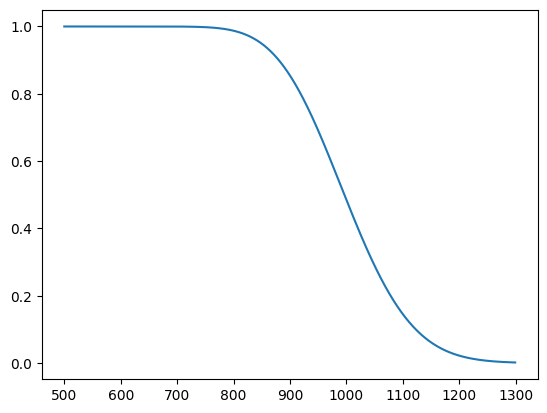

In [60]:
prob_list = []
for n in range(500, 1300):
    distr = st.binom(n, p)
    prob = distr.cdf(k)
    prob_list.append(prob)
    
plt.plot(range(500, n + 1), prob_list);

 Также по заданным параметрам построю график нормального распределения вероятностей.

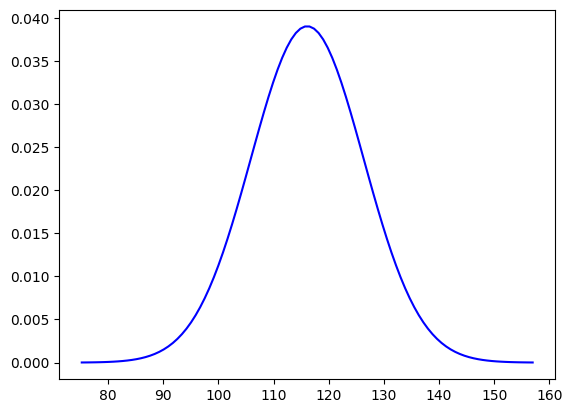

In [63]:
n = 1161
k = 99
p = 0.1
mu = n * p
sigma = np.sqrt(n * p * (1 - p))
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, color='blue');